In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import warnings
from datetime import datetime
import seaborn as sns
import os
from sklearn.metrics import classification_report

In [2]:
train = pd.read_parquet('/kaggle/input/transformer-autoencoder-dataset/train.parquet')
test = pd.read_parquet('/kaggle/input/transformer-autoencoder-dataset/test.parquet')

In [3]:
all_columns = train.columns.tolist()
new_columns = ['y'] + [f'x{i+1}' for i in range(len(all_columns)-1)]
train.columns = new_columns

In [4]:
all_columns = test.columns.tolist()
new_columns = ['y'] + [f'x{i+1}' for i in range(len(all_columns)-1)]
test.columns = new_columns

In [5]:
train.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21
0,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000
1,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000
2,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000
3,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000
4,0.0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,...,1.426367,0.000000,0.921661,-1.190432,-1.615589,0.000000,0.651114,-0.654227,-1.274345,3.101961


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


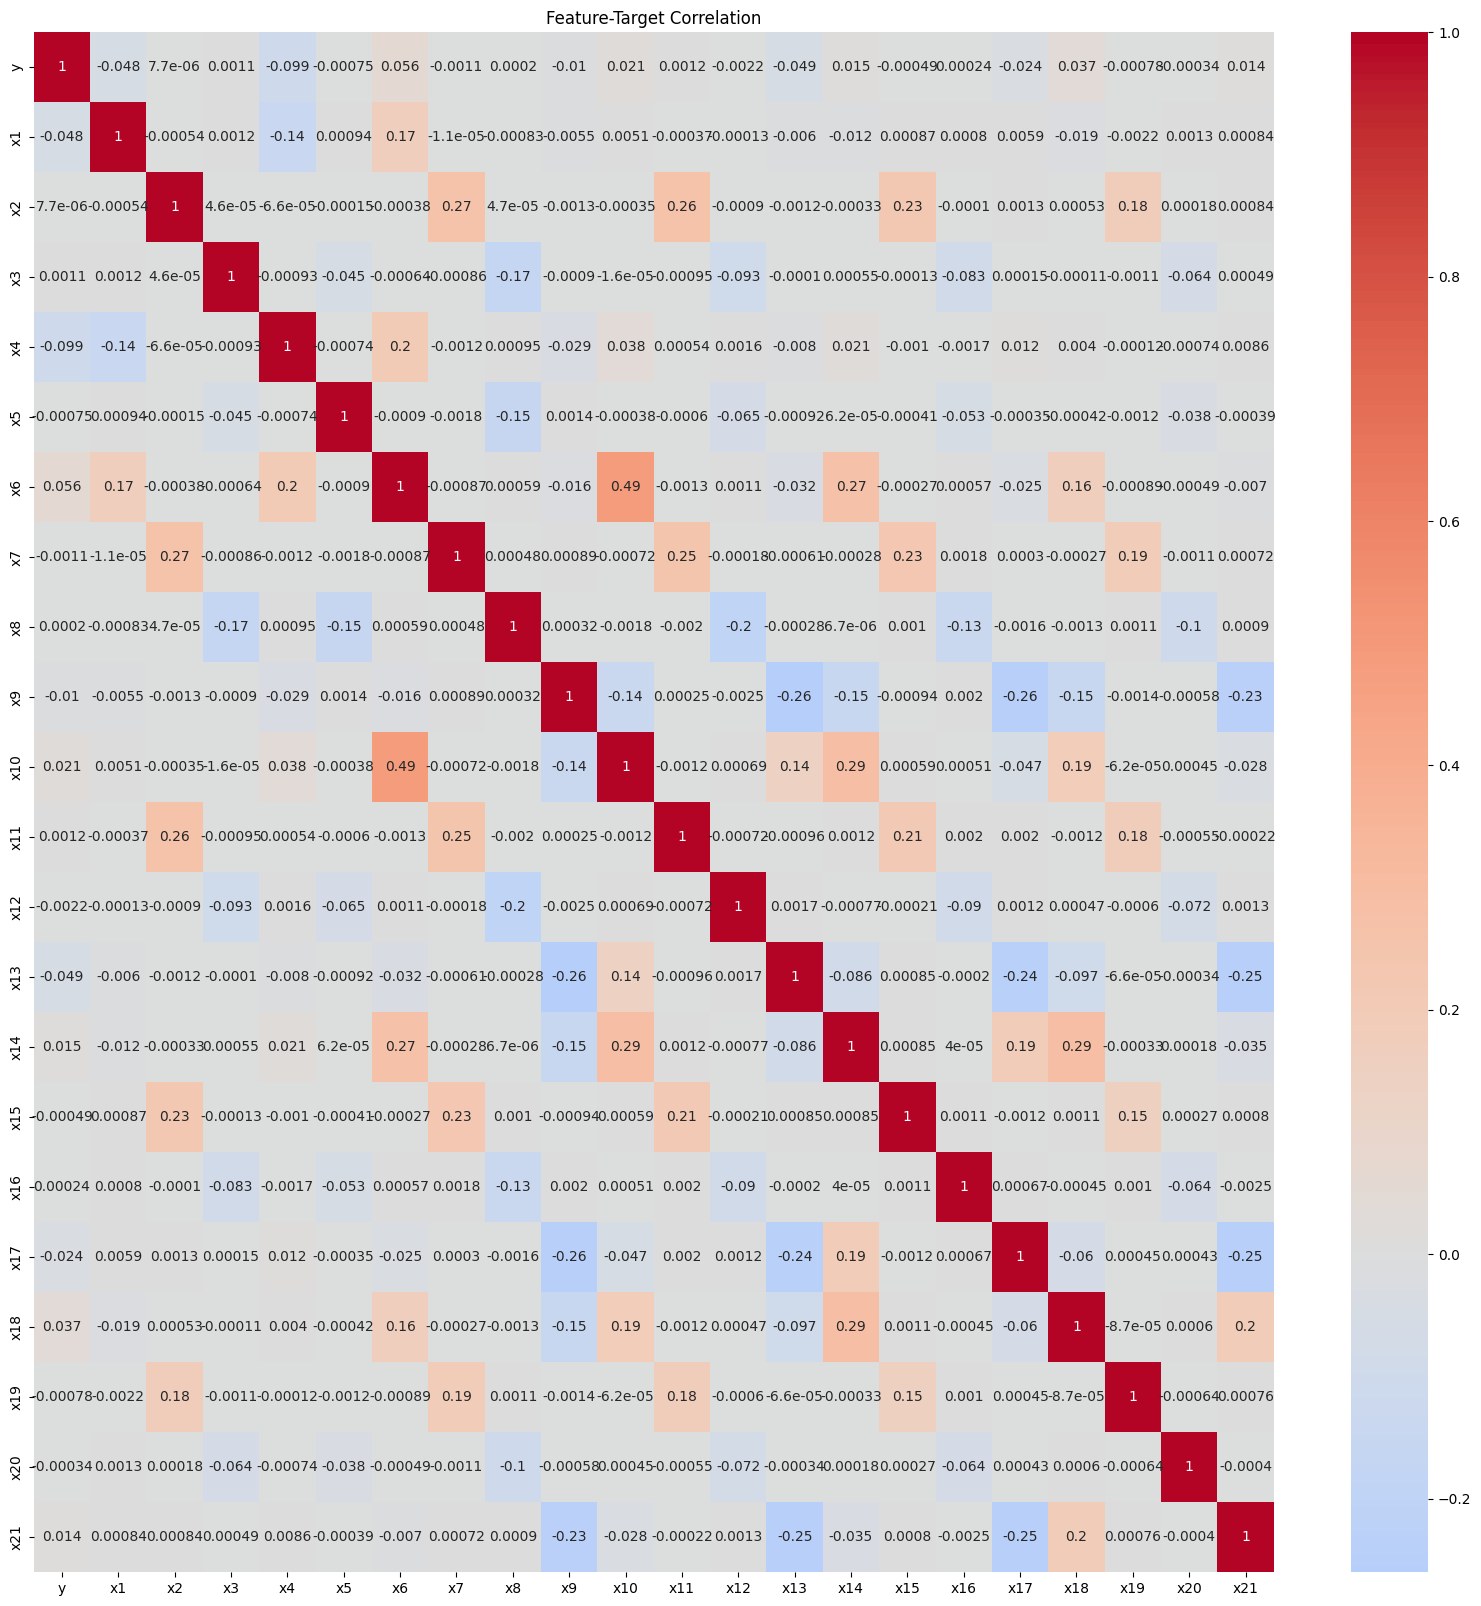

In [6]:
# Calculate correlations
corr_matrix = train.corr(method='pearson')  
target_corr = corr_matrix['y'].sort_values(ascending=False)

# Plot
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Feature-Target Correlation")
plt.show()

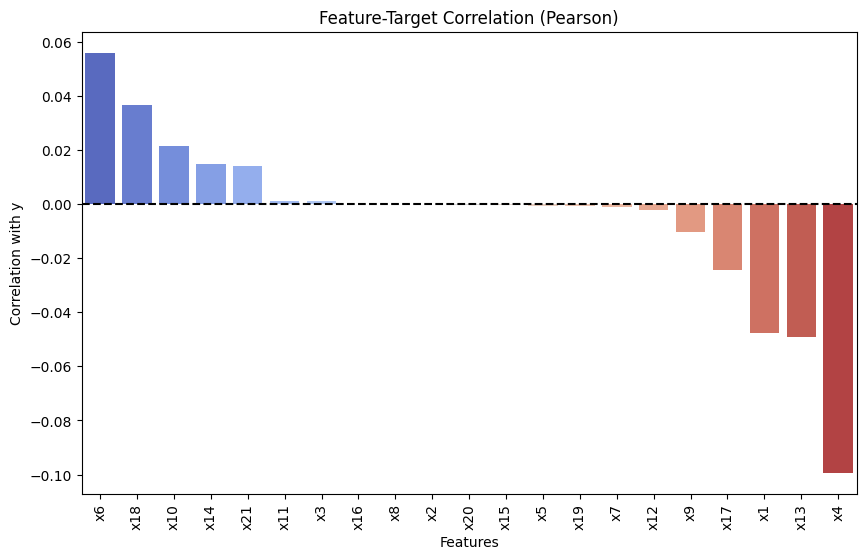

In [7]:
# Calculate correlations with target
target_corr = train.corr(method='pearson')['y'].sort_values(ascending=False)

# Drop 'y' (to avoid self-correlation)
target_corr = target_corr.drop('y', errors='ignore')

# Plot (bar plot for clarity)
plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.index, y=target_corr.values, palette='coolwarm')
plt.axhline(0, color='black', linestyle='--')  # Add zero line
plt.title("Feature-Target Correlation (Pearson)")
plt.xlabel("Features")
plt.ylabel("Correlation with y")
plt.xticks(rotation=90)
plt.show()

There is a good relation between x14, x6, x13, x1, x18, x17, x10, x14, x21, x9 (in decreasing)and the target.

In [8]:
train.describe()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21
count,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,...,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06
mean,5.295173e-01,9.913835e-01,9.536004e-04,-7.374538e-04,9.981472e-01,-7.672762e-04,9.906851e-01,-7.506974e-04,5.101967e-04,1.000775e+00,...,2.217892e-04,1.000496e+00,9.924057e-01,2.098324e-03,6.868487e-05,9.992596e-01,9.860794e-01,-7.943798e-04,-1.301046e-03,9.980434e-01
std,4.991282e-01,5.649400e-01,1.008487e+00,1.005848e+00,5.991567e-01,1.006687e+00,4.751833e-01,1.010139e+00,1.006215e+00,1.027788e+00,...,1.006862e+00,1.049272e+00,4.867730e-01,1.008249e+00,1.005804e+00,1.193635e+00,5.057663e-01,1.007892e+00,1.005938e+00,1.399439e+00
min,0.000000e+00,2.746966e-01,-2.434976e+00,-1.742508e+00,6.259872e-04,-1.743944e+00,1.386017e-01,-2.969725e+00,-1.741237e+00,0.000000e+00,...,-1.742372e+00,0.000000e+00,2.636076e-01,-2.729663e+00,-1.742069e+00,0.000000e+00,3.653542e-01,-2.497265e+00,-1.742691e+00,0.000000e+00
25%,0.000000e+00,5.907533e-01,-7.363746e-01,-8.719308e-01,5.762654e-01,-8.717909e-01,6.788095e-01,-6.882352e-01,-8.680962e-01,0.000000e+00,...,-8.707339e-01,0.000000e+00,6.512039e-01,-6.970776e-01,-8.711343e-01,0.000000e+00,6.175240e-01,-7.150230e-01,-8.720338e-01,0.000000e+00
50%,1.000000e+00,8.535544e-01,9.198132e-04,9.714414e-04,8.915848e-01,-1.158754e-03,8.942697e-01,-1.015666e-03,7.152493e-04,1.086538e+00,...,3.514990e-04,0.000000e+00,8.977762e-01,2.903640e-03,-7.519117e-04,0.000000e+00,8.679899e-01,-4.606903e-04,-4.703478e-03,0.000000e+00
75%,1.000000e+00,1.236592e+00,7.391881e-01,8.693294e-01,1.293202e+00,8.711392e-01,1.170740e+00,6.871941e-01,8.694214e-01,2.173076e+00,...,8.715371e-01,2.214872e+00,1.222500e+00,7.019747e-01,8.708400e-01,2.548224e+00,1.222147e+00,7.141017e-01,8.699407e-01,3.101961e+00
max,1.000000e+00,8.711782e+00,2.434868e+00,1.743236e+00,9.900929e+00,1.743257e+00,8.382610e+00,2.969674e+00,1.741454e+00,2.173076e+00,...,1.743175e+00,2.214872e+00,8.864838e+00,2.730009e+00,1.742884e+00,2.548224e+00,1.162123e+01,2.498009e+00,1.743372e+00,3.101961e+00


In [9]:
train.isna().sum()

y      0
x1     0
x2     0
x3     0
x4     0
x5     0
x6     0
x7     0
x8     0
x9     0
x10    0
x11    0
x12    0
x13    0
x14    0
x15    0
x16    0
x17    0
x18    0
x19    0
x20    0
x21    0
dtype: int64

In [10]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Create models directory
os.makedirs('models', exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Data Preparation

In [11]:
def prepare_data(train_df, test_df, target_col):
    """Prepare data loaders with 8192 batch size"""
    X_train = train_df.drop(columns=[target_col]).values
    y_train = train_df[target_col].values
    X_test = test_df.drop(columns=[target_col]).values
    y_test = test_df[target_col].values
    
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    BATCH_SIZE = 8192
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    return train_loader, test_loader

# 2. Model Definitions

In [12]:
class TransformerAutoencoder(nn.Module):
    def __init__(self, input_dim=21, d_model=64, num_heads=4, num_layers=2, 
                 d_ff=256, dropout=0.1):
        super().__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=num_heads,
                dim_feedforward=d_ff,
                dropout=dropout,
                batch_first=True
            ),
            num_layers=num_layers
        )
        self.input_proj = nn.Linear(input_dim, d_model)
        self.decoder = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, input_dim)
        )
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.input_proj(x)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.squeeze(1)

class BinaryClassifier(nn.Module):
    def __init__(self, input_size=42, hidden_size=128, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size//2, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x).squeeze()

class FullModel(nn.Module):
    def __init__(self, tae, classifier):
        super().__init__()
        self.tae = tae
        self.classifier = classifier
        
    def forward(self, x):
        recon = self.tae(x)
        combined = torch.cat([x, recon], dim=1)
        return self.classifier(combined)

# 3. Training Utilities

In [13]:
def save_model(model, model_type, epoch, metric):
    """Save model with metrics in filename"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"models/best_{model_type}_epoch{epoch}_{metric:.4f}_{timestamp}.pth"
    torch.save(model.state_dict(), filename)
    return filename

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC Curve (AUC = {roc_auc_score(y_true, y_scores):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_preds_binary = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (outputs > 0.5).float()
            all_preds.extend(outputs.cpu().numpy())
            all_preds_binary.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds_binary)
    auc = roc_auc_score(all_labels, all_preds)
    return acc, auc, all_labels, all_preds_binary

def train_autoencoder(model, train_loader, test_loader, optimizer, scheduler, epochs, patience=5):
    model.train()
    criterion = nn.MSELoss()
    best_loss = float('inf')
    history = []
    no_improve = 0
    
    epoch_pbar = tqdm(range(epochs), desc="Autoencoder Training")
    for epoch in epoch_pbar:
        # Training
        model.train()
        running_loss = 0.0
        for inputs, _ in train_loader:
            inputs = inputs.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss/len(train_loader)
        
        # Evaluation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, _ in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, inputs).item()
        
        val_loss /= len(test_loader)
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        
        # Save best model
        if val_loss < best_loss:
            best_loss = val_loss
            ae_path = save_model(model, "autoencoder", epoch+1, val_loss)
            no_improve = 0
        else:
            no_improve += 1
        
        history.append({
            'epoch': epoch+1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'lr': current_lr
        })
        
        epoch_pbar.set_postfix(val_loss=f"{val_loss:.4f}", lr=current_lr)
        
        if no_improve >= patience:
            tqdm.write(f"\nEarly stopping at epoch {epoch+1} - no improvement for {patience} epochs")
            break
    
    return history, ae_path

def train_classifier(model, train_loader, test_loader, optimizer, scheduler, epochs, patience=5):
    model.train()
    criterion = nn.BCELoss()
    best_auc = 0.0
    history = []
    no_improve = 0
    
    # Initialize tqdm with leave=True to keep progress bar
    epoch_pbar = tqdm(range(epochs), desc="Training", leave=True)
    
    # Print header
    tqdm.write("\nEpoch  Train Acc  Val Acc  Val AUC   LR")
    tqdm.write("----------------------------------------")
    
    for epoch in epoch_pbar:
        # Training
        model.train()
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_acc = correct/total
        
        # Evaluation
        val_acc, val_auc, val_labels, val_preds = evaluate_model(model, test_loader)
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step(1-val_auc)
        
        # Save best model
        if val_auc > best_auc:
            best_auc = val_auc
            clf_path = save_model(model, "classifier", epoch+1, val_auc)
            no_improve = 0
        else:
            no_improve += 1
        
        # Update progress bar description
        epoch_pbar.set_description(f"Epoch {epoch+1}")
        
        # Print metrics using tqdm.write to avoid progress bar interference
        tqdm.write(f"{epoch+1:5d}  {train_acc:.4f}    {val_acc:.4f}   {val_auc:.4f}  {current_lr:.6f}")
        
        history.append({
            'epoch': epoch+1,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'val_auc': val_auc,
            'lr': current_lr
        })
        
        if no_improve >= patience:
            tqdm.write(f"\nEarly stopping at epoch {epoch+1} - no improvement for {patience} epochs")
            break
    
    # Final confusion matrix
    tqdm.write("\nFinal Validation Metrics:")
    _, _, val_labels, val_preds = evaluate_model(model, test_loader)
    plot_confusion_matrix(val_labels, val_preds)
    
    return history, clf_path

# 4. Main Execution

=== Autoencoder Training ===


Autoencoder Training:   0%|          | 0/20 [00:00<?, ?it/s]


=== Classifier Training ===


Training:   0%|          | 0/200 [00:00<?, ?it/s]


Epoch  Train Acc  Val Acc  Val AUC   LR
----------------------------------------
    1  0.6010    0.6433   0.6980  0.001000
    2  0.6508    0.6698   0.7332  0.001000
    3  0.6696    0.6786   0.7443  0.001000
    4  0.6784    0.6892   0.7561  0.001000
    5  0.6837    0.6901   0.7585  0.001000
    6  0.6873    0.6953   0.7626  0.001000
    7  0.6907    0.6964   0.7642  0.001000
    8  0.6950    0.7011   0.7706  0.000500
    9  0.6966    0.7014   0.7709  0.000500
   10  0.6979    0.7030   0.7727  0.000500
   11  0.6989    0.7030   0.7731  0.000500
   12  0.6997    0.7046   0.7742  0.000500
   13  0.7011    0.7041   0.7745  0.000500
   14  0.7033    0.7070   0.7767  0.000250
   15  0.7040    0.7069   0.7772  0.000250
   16  0.7045    0.7074   0.7775  0.000250
   17  0.7053    0.7075   0.7783  0.000250
   18  0.7051    0.7079   0.7781  0.000250
   19  0.7057    0.7078   0.7787  0.000250
   20  0.7060    0.7077   0.7786  0.000250
   21  0.7069    0.7082   0.7789  0.000250
   22  0.7073  

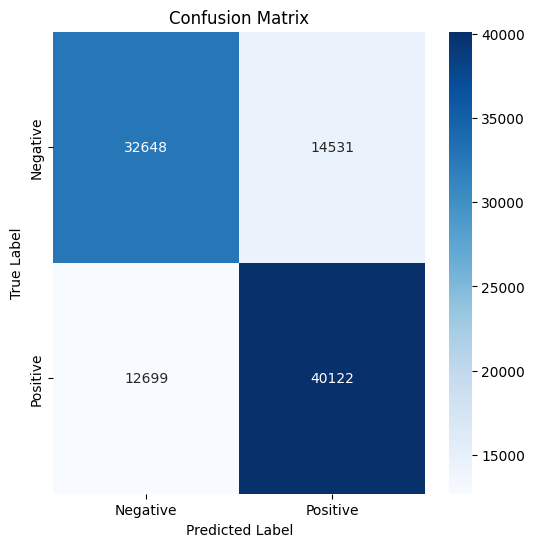


=== Final Evaluation ===
Test Accuracy: 0.7284
Test ROC-AUC: 0.8040


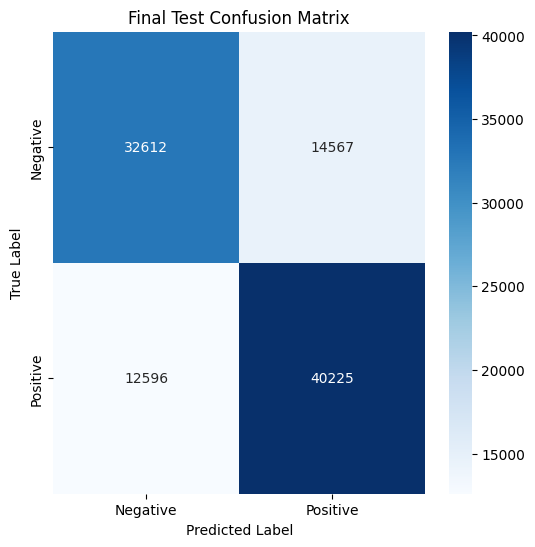

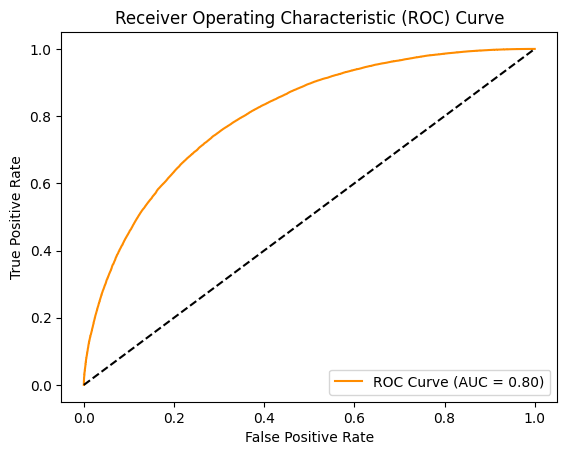


Classification Report:
              precision    recall  f1-score   support

    Negative       0.72      0.69      0.71     47179
    Positive       0.73      0.76      0.75     52821

    accuracy                           0.73    100000
   macro avg       0.73      0.73      0.73    100000
weighted avg       0.73      0.73      0.73    100000



In [14]:
def run_pipeline(train_df, test_df, target_col, ae_patience=5, clf_patience=5):
    train_loader, test_loader = prepare_data(train_df, test_df, target_col)
    
    # Initialize models
    tae = TransformerAutoencoder().to(device)
    classifier = BinaryClassifier().to(device)
    full_model = FullModel(tae, classifier).to(device)
    
    # Optimizers with initial LR of 0.001
    ae_optimizer = optim.Adam(tae.parameters(), lr=0.001)
    class_optimizer = optim.Adam(full_model.parameters(), lr=0.001)
    
    # Schedulers with min_lr=0.00025
    ae_scheduler = ReduceLROnPlateau(
        ae_optimizer, 
        mode='min', 
        patience=1, 
        factor=0.5,
        min_lr=0.00025,
        verbose=True
    )
    class_scheduler = ReduceLROnPlateau(
        class_optimizer, 
        mode='max',  # We want to maximize AUC
        patience=5, 
        factor=0.5,
        min_lr=0.00025,
        verbose=True
    )
    
    # Training
    print("=== Autoencoder Training ===")
    ae_history, ae_path = train_autoencoder(tae, train_loader, test_loader, 
                                         ae_optimizer, ae_scheduler, 
                                         epochs=20, patience=ae_patience)
    
    print("\n=== Classifier Training ===")
    class_history, clf_path = train_classifier(full_model, train_loader, test_loader,
                                            class_optimizer, class_scheduler,
                                            epochs=200, patience=clf_patience)
    
    # Load best models
    tae.load_state_dict(torch.load(ae_path))
    full_model.load_state_dict(torch.load(clf_path))
    
    # Final Evaluation - ENHANCED SECTION
    print("\n=== Final Evaluation ===")
    test_acc, test_auc, test_labels, test_preds = evaluate_model(full_model, test_loader)
    
    # Get prediction probabilities for ROC curve
    test_probs = []
    full_model.eval()
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = full_model(inputs)
            test_probs.extend(outputs.cpu().numpy())
    
    # Print metrics
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test ROC-AUC: {test_auc:.4f}")
    
    # Plot visualizations
    plot_confusion_matrix(test_labels, test_preds, title='Final Test Confusion Matrix')
    plot_roc_curve(test_labels, test_probs)  # NEW: Add ROC curve plotting
    
    # Additional metrics
    print("\nClassification Report:")
    print(classification_report(test_labels, test_preds, 
                               target_names=['Negative', 'Positive']))
    
    return {
        'model': full_model,
        'ae_history': ae_history,
        'class_history': class_history,
        'ae_path': ae_path,
        'clf_path': clf_path,
        'test_metrics': {
            'accuracy': test_acc, 
            'auc': test_auc,
            'true_labels': test_labels,
            'pred_labels': test_preds,
            'pred_probs': test_probs  # NEW: Store probabilities
        }
    }

# Example usage:
results = run_pipeline(train, test, 'y', ae_patience=5, clf_patience=5)